## Objectif :  

Dans ce notebook, nous allons réaliser plusieurs tests de prédiction de la variable TARGET à partir des features. Pour ce faire, nous devons tout d'abord diviser le df "data_train" vers une partie entrainement et autre test. Ensuite, Nous allons lancer notre baseline de comparaison basé sur l'algorithme grâce à hyperopt, nous allons lancer la prédiction afin d'optimiser les hyperparamètres.   

La bibliothèque hyperopt a un but similaire à gridsearch, mais au lieu de faire une recherche exhaustive de l’espace de paramètre, il évalue quelques points de données bien choisis, puis extrapole la solution optimale basée sur la modélisation. En pratique, cela signifie qu’il faut souvent beaucoup moins d’itérations pour trouver une bonne solution.

In [1]:
import pandas as pd
import seaborn as sns
import time, pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# charger les données d'entrainement
data_train = pd.read_csv('Data/preprocessed_Data/data_train.csv', index_col='SK_ID_CURR')

In [3]:
data_train.shape

(307511, 248)

In [4]:
# charger la variable TARGET
TARGET= pd.read_csv('Data/preprocessed_Data/TARGET.csv', index_col='SK_ID_CURR')

In [5]:
TARGET.shape

(307511, 1)

### Séparation train_split et test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 248), (92254, 248), (215257, 1), (92254, 1))

### Baseline Model: DummyClassifier  

Afin d'avoir une première idée des performances possibles, la modélisation par DummyClassifier permettra d'obtenir une baseline. Nous nous basons sur les résultats trouvés comme base de comparaison.   


In [8]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.dummy import DummyClassifier

In [11]:
# définir le paramètre space pour l'optimisation  
space = {
    "strategy": hp.choice("strategy", ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']),
   }

Notre fonction de minimisation est appelée hyperparamter_tuning et l’algorithme de classification pour optimiser son hyperparamètre est DummyClassifier. J’utilise la validation croisée pour éviter le overfitting, puis la fonction retourne une valeur de perte et son état.  
Cela signifie que pendant le processus d’optimisation, nous formons le modèle avec des valeurs d’hyperparamètres sélectionnées et nous prédisons le TARGET, puis nous évaluons l’erreur de prédiction et nous la rendons à l’optimiseur. L’optimiseur décidera quelles valeurs vérifier et itérer à nouveau.

In [12]:
# define objective function

def hyperparameter_tuning(params):
    clf = DummyClassifier(**params)
    acc = cross_val_score(clf, X_train, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [13]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100
)

100%|██████████| 100/100 [00:44<00:00,  2.23trial/s, best loss: -0.9191106446044444]


--> best loss = -0.919 signifie que c'est un modèle avec accuracy= 91,91%

In [14]:
print("Best: {}".format(best))

Best: {'strategy': 1}


--> la meilleur valeur du paramètre "strategy" est celui dans la liste dont l'indice est 1 --> strategy = "prior".  
    Nous allons fitter le modèle sur nos données puis  prédire notre target. 

In [15]:
Dummy_model = DummyClassifier(strategy='prior')

In [16]:
Dummy_model.fit(X=X_train,y=y_train)


DummyClassifier()

l’efficacité du modèle est déterminée en observant l’aire sous la courbe (AUC). Ainsi, le modèle le plus efficace a une AUC égale à 1, et le modèle le moins efficace a une AUC égale à 0,5.

In [17]:
from sklearn.metrics import roc_curve, auc  
def Performance(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    show()

In [18]:
roc_auc = roc_auc_score(y_test, Dummy_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Dummy_model.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


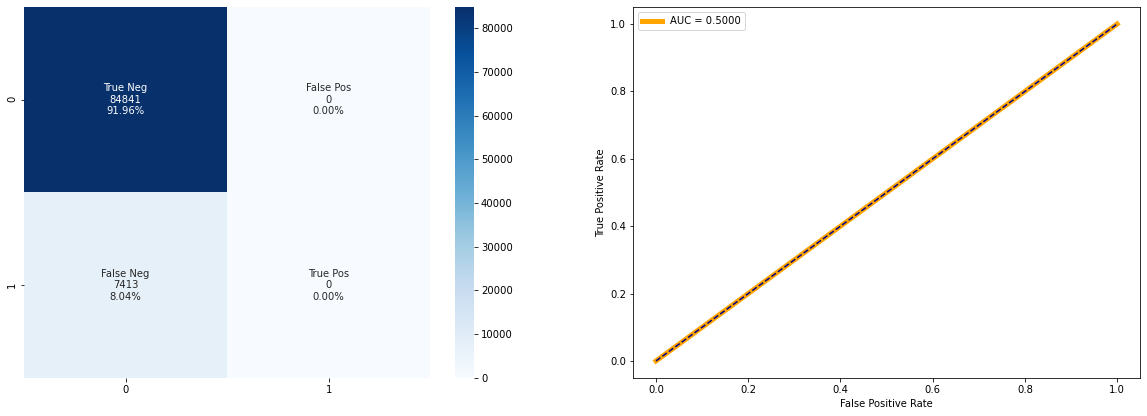

In [20]:
Performance(Dummy_model, y_test, Dummy_model.predict(X_test), Dummy_model.predict_proba(X_test)[:,1])

L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets choisis au hasard, TARGET =0 OU =1. Une AUC de 0,5 (50%) indique que le marqueur est non-informatif.   
--> par conséquent, ce modèle montre qu'il est non performant et que la valeur d'accuracy = 91,91% est une valeur trompeuse. 

--> ceci est dû au déséquilibrage des deux classes TARGET= --> 0 et TARGET = 1.  --> Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

### Oversampling Data en utilisant SMOTE  
SMOTE avec Imbalance Data en utilisant imblearn module

In [21]:
print("Classe 1, avant utilisation de SMOTE: {} ".format(sum(y_train==1)))
print("Classe 0, avant utilisation SMOTE: {} ".format(sum(y_train==0)))

Classe 1, avant utilisation de SMOTE: 17412 
Classe 0, avant utilisation SMOTE: 197845 


In [22]:
!pip install imblearn

**over-sampling:**  au lieu de créer des copies exactes des enregistrements de classe minoritaire, nous pouvons introduire de petites variations dans ces copies, créant des échantillons synthétiques plus diversifiés.

In [23]:
# équilibrage des classes

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [24]:
# reverification des classes

print("Classe 1, après utilisation de SMOTE: {} ".format(sum(y_train_res==1)))
print("Classe 0, après utilisation de SMOTE: {} ".format(sum(y_train_res==0)))

Classe 1, après utilisation de SMOTE: 197845 
Classe 0, après utilisation de SMOTE: 197845 


### Re-entrainement du modèle baseline après équilibrage des classes

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
def hyperparameter_tuning(params):
    clf = DummyClassifier(**params, n_jobs=-1)
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [27]:
trials = Trials()

In [28]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100
    
)

ValueError: invalid number of arguments

In [ ]:
print("Best: {}".format(best))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      0.50      0.65     84841
         1.0       0.08      0.49      0.14      7413

    accuracy                           0.50     92254
   macro avg       0.50      0.50      0.39     92254
weighted avg       0.85      0.50      0.61     92254



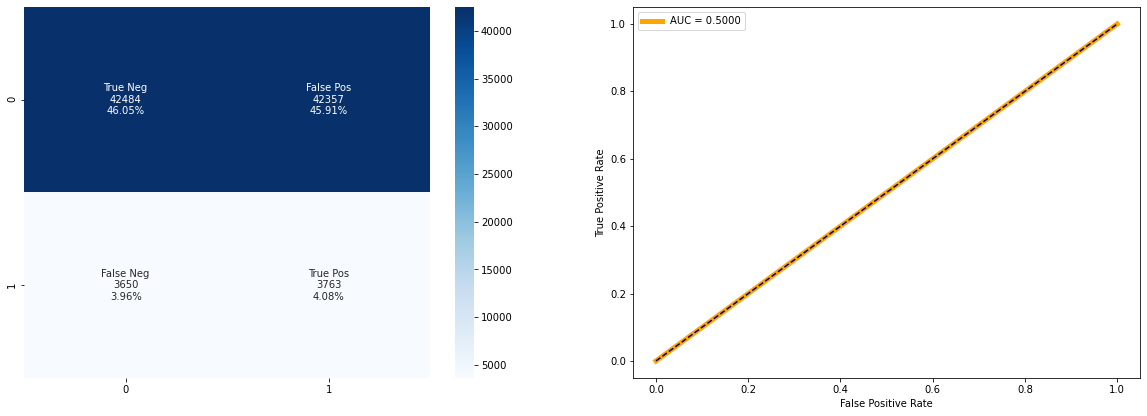

In [29]:
Dummy_model = DummyClassifier(strategy='uniform')
Dummy_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, Dummy_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Dummy_model.predict(X_test)))

Performance(Dummy_model, y_test, Dummy_model.predict(X_test), Dummy_model.predict_proba(X_test)[:,1])

## Entrainer d'autres modèles de classification  

### 1. Random Forest  

Les forêts aléatoires fonctionnent en faisant la moyenne des prédictions de nombreux arbres de décision - l’idée est qu’en faisant la moyenne de nombreux arbres, les erreurs de chaque arbre sont aplanies. Chaque arbre de décision peut être quelque peu overfitted, en faisant la moyenne, le résultat final devrait être bon.

Les paramètres importants à régler sont :

Nombre d’arbres dans la forêt (n_estimators)
Complexité de l’arborescence (max_depth)

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
space = {
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

In [33]:
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(n_jobs=4, **params)
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy", cv=StratifiedKFold()).mean()
    return {"loss": -acc, "status": STATUS_OK}


In [35]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100
    
)

ValueError: invalid number of arguments

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
rf_model = RandomForestClassifier(n_estimators = ... , max_depth=  ...)
rf_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rf_model.predict(X_test)))

Performance(rf_model, y_test, rf_model.predict(X_test), rf_model.predict_proba(X_test)[:,1])

### 2. XGBoost    

XGBoost est également basé sur un ensemble d’arbres de décision, mais différent de la forêt aléatoire. Les arbres ne sont pas moyennés, mais ajoutés. Les arbres de décision sont formés pour corriger les résidus des arbres précédents. L’idée est que de nombreux petits arbres de décision sont formés, chacun ajoutant un peu d’information pour améliorer les prévisions globales.  

Les paramètres les plus importants sont :

- Nombre d’arbres (n_estimators)
- Taux d’apprentissage - les arbres postérieurs ont moins d’influence (taux d’apprentissage)
- Complexité de l’arborescence (max_depth)
- Gamma - Faire des arbres individuels conservateurs, réduire le overfitting
- échantillon de colonne par arbre - réduire le overfitting

In [ ]:
import xgboost as xgb

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

In [ ]:
def hyperparameter_tuning(params):
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy", cv=StratifiedKFold()).mean()
    return {"loss": -acc, "status": STATUS_OK}


In [ ]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100
    
)

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree= ..., gamma: ... , max_depth= ...)
xgb_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

Performance(xgb_model, y_test, xgb_model.predict(X_test), xgb_model.predict_proba(X_test)[:,1])

### 3. LightGBM   

LightGBM est très similaire à xgboost, il est également utilise une approche d’arbre boosté par gradient. L’explication ci-dessus tient également.

Les paramètres importants à régler sont :

- Nombre d’estimateurs
- Complexité de l’arbre - en lightgbm qui est contrôlé par le nombre de feuilles (num_leaves)
- Taux d’apprentissage
- Feature fraction

In [ ]:
import lightgbm as lgbm

In [ ]:
space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}


In [ ]:
def hyperparameter_tuning(params):
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy", cv=StratifiedKFold()).mean()
    return {"loss": -acc, "status": STATUS_OK}


In [ ]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100
    
)

In [ ]:
lgbm_model = lgbm.LGBMClassifier(num_leaves = ... , colsample_bytree= ...)
lgbm_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_model.predict(X_test)))

Performance(lgbm_model, y_test, lgbm_model.predict(X_test), lgbm_model.predict_proba(X_test)[:,1])